In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
import numpy as np


file_path = "/content/drive/MyDrive/Iqram Sir/Final_data_train.csv"
file_path_valid = "/content/drive/MyDrive/Iqram Sir/Final_data_valid.csv"

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx
import matplotlib.pyplot as plt

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


kinz_df = pd.read_csv(file_path)

data = kinz_df[kinz_df['walking_speed']=='Fast'].reset_index(drop=True)


# Inspect the dataset columns to identify joint coordinate columns
columns = data.columns.tolist()
print(columns)

# Identify joint columns and the target column
joint_columns = [col for col in columns if any(j in col for j in ['HEAD', 'NOSE', 'EYE', 'EAR', 'FOOT', 'HAND', 'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE', 'SHOULDER', 'ELBOW', 'WRIST', 'HANDTIP', 'THUMB', 'HIP', 'KNEE', 'ANKLE'])]
target_column = 'frailty_class'

# Extract the target variable y
y = data[target_column].values

# Extract XYZ coordinates for the joints and preprocess data
def preprocess_data(df, joint_columns, num_joints=32, num_channels=3, num_persons=1):
    unique_patient_ids = df['patient_id'].unique()
    N = len(unique_patient_ids)
    T = df.groupby('patient_id').size().max()  # Assuming each patient has a sequence of frames
    V = num_joints
    C = num_channels
    M = num_persons

    data = np.zeros((N, C, T, V, M))
    y = np.zeros(N)  # Target array for the labels

    for i, pid in enumerate(unique_patient_ids):
        patient_data = df[df['patient_id'] == pid][joint_columns].values
        num_frames = patient_data.shape[0]
        for t in range(num_frames):
            frame_data = patient_data[t].reshape(-1, C).T
            data[i, :, t, :frame_data.shape[1], 0] = frame_data
        y[i] = df[df['patient_id'] == pid][target_column].values[0]  # Assuming one label per patient

    return torch.tensor(data, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Preprocess the dataset
num_joints = len(joint_columns) // 3
preprocessed_data, preprocessed_labels = preprocess_data(data, joint_columns, num_joints=num_joints)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, preprocessed_labels, test_size=0.2, random_state=42)

# Convert targets to torch tensors and move to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Define the modified ST-GCN model
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(GraphConvolution, self).__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels, out_channels * kernel_size, kernel_size=1, stride=stride)

    def forward(self, x, A):
        N, C, T, V = x.size()
        x = self.conv(x)
        x = x.view(N, self.kernel_size, -1, T, V)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))
        return x.contiguous()

class TemporalConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(TemporalConvolution, self).__init__()
        pad = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0), stride=(stride, 1))

    def forward(self, x):
        return self.conv(x)

class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, num_joints, edge_importance_weighting=True):
        super(STGCN, self).__init__()

        # Define the adjacency matrix
        A = torch.eye(num_joints).unsqueeze(0).repeat(3, 1, 1)

        self.data_bn = nn.BatchNorm1d(in_channels * num_joints)

        # Define the layers
        self.gcn1 = GraphConvolution(in_channels, 64, kernel_size=3)
        self.tcn1 = TemporalConvolution(64, 64)
        self.gcn2 = GraphConvolution(64, 128, kernel_size=3)
        self.tcn2 = TemporalConvolution(128, 128)
        self.gcn3 = GraphConvolution(128, 256, kernel_size=3)
        self.tcn3 = TemporalConvolution(256, 256)

        self.fc = nn.Linear(256, num_class)

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in range(3)
            ])
        else:
            self.edge_importance = [1] * 3

        self.A = nn.Parameter(A, requires_grad=False)

    def forward(self, x):
        N, C, T, V, M = x.size()
        x = x.permute(0, 4, 3, 1, 2).contiguous().view(N * M, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, M, V, C, T).permute(0, 1, 3, 4, 2).contiguous().view(N * M, C, T, V)

        # Forward through the layers
        x = self.gcn1(x, self.A * self.edge_importance[0])
        x = self.tcn1(x)
        x = self.gcn2(x, self.A * self.edge_importance[1])
        x = self.tcn2(x)
        x = self.gcn3(x, self.A * self.edge_importance[2])
        x = self.tcn3(x)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, M, -1, 1, 1).mean(dim=1)
        x = x.view(N, -1)

        return self.fc(x)







Using device: cuda
['patient_id', 'trial', 'walking_speed', 't_uniform', 'ACC_1', 'ACC_2', 'ACC_3', 'ACC_4', 'ACC_5', 'ACC_6', 'accel_energy_total', 'footfall_event_times', 'PELVIS_X', 'SPINE_NAVAL_X', 'SPINE_CHEST_X', 'NECK_X', 'CLAVICLE_LEFT_X', 'SHOULDER_LEFT_X', 'ELBOW_LEFT_X', 'WRIST_LEFT_X', 'HAND_LEFT_X', 'HANDTIP_LEFT_X', 'THUMB_LEFT_X', 'CLAVICLE_RIGHT_X', 'SHOULDER_RIGHT_X', 'ELBOW_RIGHT_X', 'WRIST_RIGHT_X', 'HAND_RIGHT_X', 'HANDTIP_RIGHT_X', 'THUMB_RIGHT_X', 'HIP_LEFT_X', 'KNEE_LEFT_X', 'ANKLE_LEFT_X', 'FOOT_LEFT_X', 'HIP_RIGHT_X', 'KNEE_RIGHT_X', 'ANKLE_RIGHT_X', 'FOOT_RIGHT_X', 'HEAD_X', 'NOSE_X', 'EYE_LEFT_X', 'EAR_LEFT_X', 'EYE_RIGHT_X', 'EAR_RIGHT_X', 'PELVIS_Y', 'SPINE_NAVAL_Y', 'SPINE_CHEST_Y', 'NECK_Y', 'CLAVICLE_LEFT_Y', 'SHOULDER_LEFT_Y', 'ELBOW_LEFT_Y', 'WRIST_LEFT_Y', 'HAND_LEFT_Y', 'HANDTIP_LEFT_Y', 'THUMB_LEFT_Y', 'CLAVICLE_RIGHT_Y', 'SHOULDER_RIGHT_Y', 'ELBOW_RIGHT_Y', 'WRIST_RIGHT_Y', 'HAND_RIGHT_Y', 'HANDTIP_RIGHT_Y', 'THUMB_RIGHT_Y', 'HIP_LEFT_Y', 'KNEE_LEF

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([22, 3, 959, 32, 1]),
 torch.Size([6, 3, 959, 32, 1]),
 torch.Size([22]),
 torch.Size([6]))

# Train the model

In [ ]:
# Train the model
def train(model, X_train, y_train, X_test, y_test, epochs=20, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = accuracy_score(y_test.cpu(), test_predicted.cpu())

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}')

# Instantiate the model
num_joints = len(joint_columns) // 3
in_channels = 3  # x, y, z coordinates
num_class = 2  # frailty class 0 or 1
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)






train(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Function to evaluate the model
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_true = y_test.cpu().numpy()
        y_pred = predicted.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print('\nClassification Report:')
        print(classification_report(y_true, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# Evaluate the model
evaluate(model, X_test, y_test)



# Training function with model saving

In [ ]:
import os


# Training function with model saving
def train_and_save(model, optimizer, X_train, y_train, X_test, y_test, epochs=20, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    save_dir = './model_checkpoints'
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, 'stgcn_model.pth')

    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = accuracy_score(y_test.cpu(), test_predicted.cpu())

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}')

        # Save the model at the end of each epoch
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss.item()
        }, model_save_path)
        print(f"Model saved to {model_save_path}")

# Instantiate the model and optimizer
num_joints = len(joint_columns) // 3
in_channels = 3  # x, y, z coordinates
num_class = 2  # frailty class 0 or 1
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




# Train the model and save it
train_and_save(model, optimizer, X_train, y_train, X_test, y_test, epochs=30, lr=0.01)

Epoch 1/30, Train Loss: 0.7014903426170349, Train Accuracy: 0.5, Test Loss: 14.458362579345703, Test Accuracy: 0.5
Model saved to ./model_checkpoints/stgcn_model.pth
Epoch 2/30, Train Loss: 24.781736373901367, Train Accuracy: 0.2727272727272727, Test Loss: 5635.41943359375, Test Accuracy: 0.16666666666666666
Model saved to ./model_checkpoints/stgcn_model.pth
Epoch 3/30, Train Loss: 6594.8173828125, Train Accuracy: 0.36363636363636365, Test Loss: 812.032958984375, Test Accuracy: 0.6666666666666666
Model saved to ./model_checkpoints/stgcn_model.pth
Epoch 4/30, Train Loss: 1174.5206298828125, Train Accuracy: 0.6363636363636364, Test Loss: 2546.295654296875, Test Accuracy: 0.5
Model saved to ./model_checkpoints/stgcn_model.pth
Epoch 5/30, Train Loss: 4503.61279296875, Train Accuracy: 0.45454545454545453, Test Loss: 1251.0382080078125, Test Accuracy: 0.5
Model saved to ./model_checkpoints/stgcn_model.pth
Epoch 6/30, Train Loss: 1291.00732421875, Train Accuracy: 0.6363636363636364, Test Loss

# Training function with early stopping and model saving

In [ ]:
import os


# Training function with early stopping and model saving
def train_and_save_with_early_stopping(model, optimizer, X_train, y_train, X_val, y_val, epochs=20, lr=0.001, patience=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    save_dir = './model_checkpoints'
    os.makedirs(save_dir, exist_ok=True)
    model_save_path = os.path.join(save_dir, 'stgcn_model.pth')

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs, 1)
            val_accuracy = accuracy_score(y_val.cpu(), val_predicted.cpu())

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': loss.item()
            }, model_save_path)
            print(f"Model saved to {model_save_path}")
        else:
            epochs_without_improvement += 1
            print(f'Early stopping counter: {epochs_without_improvement} out of {patience}')

        # Early stopping
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

# Instantiate the model and optimizer
num_joints = len(joint_columns) // 3
in_channels = 3  # x, y, z coordinates
num_class = 2  # frailty class 0 or 1
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(preprocessed_data, preprocessed_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert targets to torch tensors and move to device
X_train, X_val, X_test = X_train.to(device), X_val.to(device), X_test.to(device)
y_train, y_val, y_test = y_train.to(device), y_val.to(device), y_test.to(device)

# Train the model with early stopping
train_and_save_with_early_stopping(model, optimizer, X_train, y_train, X_val, y_val, epochs=10, lr=0.001, patience=5)

# Function to evaluate the model

Model loaded from ./model_checkpoints/stgcn_model.pth
Accuracy: 0.6428571428571429
Precision: 0.6749999999999999
Recall: 0.6428571428571429
F1 Score: 0.6256684491978609

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71        14
           1       0.75      0.43      0.55        14

    accuracy                           0.64        28
   macro avg       0.68      0.64      0.63        28
weighted avg       0.67      0.64      0.63        28



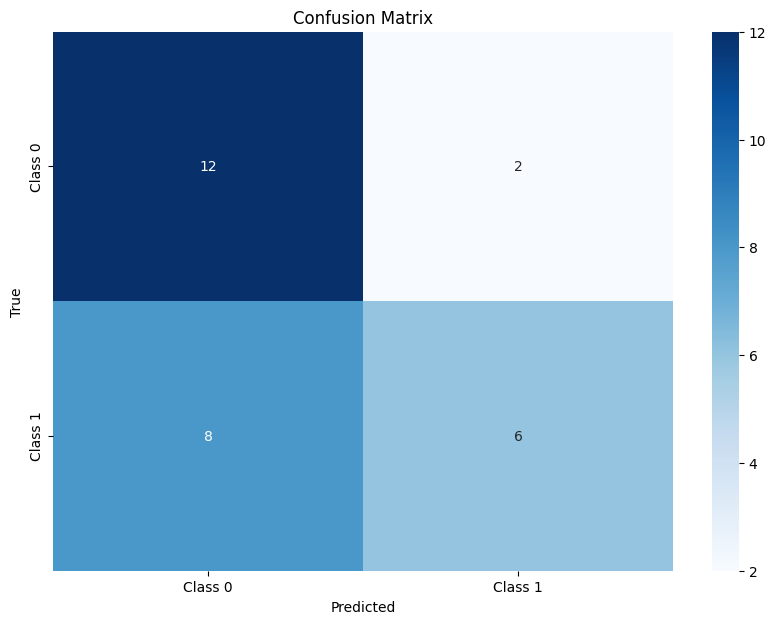

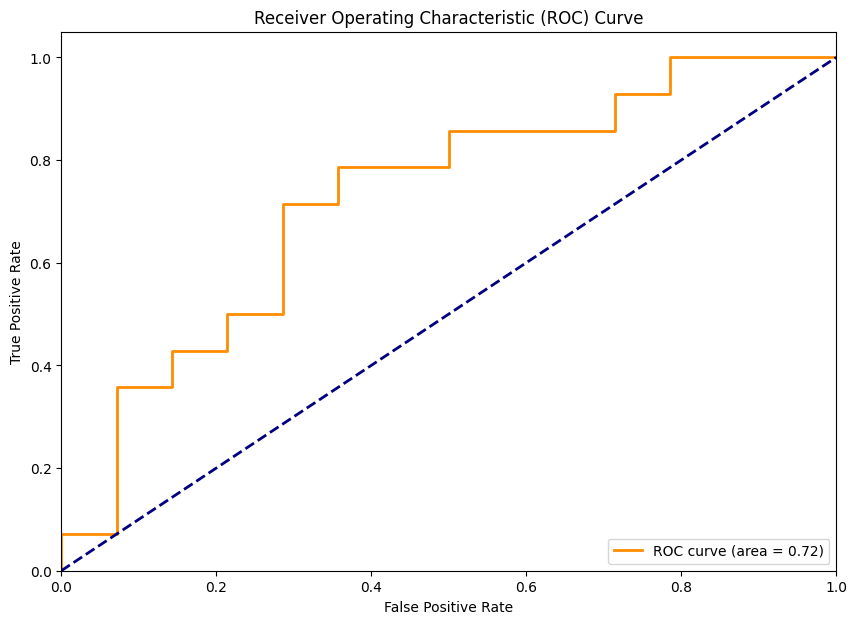

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns


# Load the model state dictionary
model_save_path = './model_checkpoints/stgcn_model.pth'
checkpoint = torch.load(model_save_path, map_location=device)

# Instantiate the model and optimizer
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Move the model to the appropriate device
model.to(device)

print(f"Model loaded from {model_save_path}")

# Function to evaluate the model
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_true = y_test.cpu().numpy()
        y_pred = predicted.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print('\nClassification Report:')
        print(classification_report(y_true, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Compute ROC curve and ROC area for each class
        y_score = outputs[:, 1].cpu().numpy()  # Assuming the second column is the positive class
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()





# Evaluate the loaded model
kinz_df_valid = pd.read_csv(file_path_valid)

data_valid = kinz_df[kinz_df['walking_speed']=='Fast'].reset_index(drop=True)

preprocessed_data_valid, preprocessed_labels_valid = preprocess_data(data_valid, joint_columns, num_joints=num_joints)


X_valid = preprocessed_data_valid.to(device)
y_valid = preprocessed_labels_valid.to(device)

evaluate(model, X_valid, y_valid)





#evaluate(model, X_test, y_test)


# Updated model

In [ ]:
kinz_df = pd.read_csv(file_path)

data = kinz_df[kinz_df['walking_speed']=='Fast'].reset_index(drop=True)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([10226, 3, 32]),
 torch.Size([10226]),
 torch.Size([2557, 3, 32]),
 torch.Size([2557]))

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# Inspect the dataset columns to identify joint coordinate columns
columns = data.columns.tolist()
print(columns)

# Identify joint columns and the target column
joint_columns = [col for col in columns if any(j in col for j in ['HEAD', 'NOSE', 'EYE', 'EAR', 'FOOT', 'HAND', 'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE', 'SHOULDER', 'ELBOW', 'WRIST', 'HANDTIP', 'THUMB', 'HIP', 'KNEE', 'ANKLE'])]
target_column = 'frailty_class'

# Extract the target variable y
y = data[target_column].values

# Extract XYZ coordinates for the joints and preprocess data
def preprocess_data(df, joint_columns, num_joints=32, num_channels=3):
    T = len(df)  # Number of frames (rows in the dataset)
    V = num_joints  # Number of joints
    C = num_channels  # Number of channels (x, y, z coordinates)

    # Initialize the data array with zeros
    data = np.zeros((T, C, V))
    y = np.zeros(T)  # Target array for the labels

    for t in range(T):
        frame_data = df.iloc[t][joint_columns].values.reshape(-1, C).T  # Reshape and transpose the frame data to match the expected shape
        data[t, :, :] = frame_data  # Assign the frame data to the data array
        y[t] = df.iloc[t][target_column]  # Assign the target label to the y array

    return torch.tensor(data, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Preprocess the data
num_joints = len(joint_columns) // 3
preprocessed_data, preprocessed_labels = preprocess_data(data, joint_columns, num_joints=num_joints)

print("Preprocessed Data Shape:", preprocessed_data.shape)  # Expected shape: (number of rows, 3, number of joints)
print("Preprocessed Labels:", preprocessed_labels)  # Expected labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, preprocessed_labels, test_size=0.2, random_state=42)

# Convert targets to torch tensors and move to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Define the modified ST-GCN model
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(GraphConvolution, self).__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels, out_channels * kernel_size, kernel_size=1, stride=stride)

    def forward(self, x, A):
        N, C, T, V = x.size()
        x = self.conv(x)
        x = x.view(N, self.kernel_size, -1, T, V)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))
        return x.contiguous()

class TemporalConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(TemporalConvolution, self).__init__()
        pad = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0), stride=(stride, 1))

    def forward(self, x):
        return self.conv(x)

class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, num_joints, edge_importance_weighting=True):
        super(STGCN, self).__init__()

        # Define the adjacency matrix
        A = torch.eye(num_joints).unsqueeze(0).repeat(3, 1, 1)

        self.data_bn = nn.BatchNorm1d(in_channels * num_joints)

        # Define the layers
        self.gcn1 = GraphConvolution(in_channels, 64, kernel_size=3)
        self.tcn1 = TemporalConvolution(64, 64)
        self.gcn2 = GraphConvolution(64, 128, kernel_size=3)
        self.tcn2 = TemporalConvolution(128, 128)
        self.gcn3 = GraphConvolution(128, 256, kernel_size=3)
        self.tcn3 = TemporalConvolution(256, 256)

        self.fc = nn.Linear(256, num_class)

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in range(3)
            ])
        else:
            self.edge_importance = [1] * 3

        self.A = nn.Parameter(A, requires_grad=False)

    def forward(self, x):
        N, C, V = x.size()
        x = x.view(N, C, 1, V).permute(0, 2, 1, 3)  # Reshape to (N, 1, C, V)
        x = self.data_bn(x.view(N, C * V)).view(N, 1, C, V)

        # Forward through the layers
        x = self.gcn1(x, self.A * self.edge_importance[0])
        x = self.tcn1(x)
        x = self.gcn2(x, self.A * self.edge_importance[1])
        x = self.tcn2(x)
        x = self.gcn3(x, self.A * self.edge_importance[2])
        x = self.tcn3(x)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1)

        return self.fc(x)

# Training function
def train(model, X_train, y_train, X_test, y_test, epochs=20, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = accuracy_score(y_test.cpu(), test_predicted.cpu())

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}')

# Instantiate the model
num_joints = len(joint_columns) // 3
in_channels = 3  # x, y, z coordinates
num_class = 2  # frailty class 0 or 1
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)

# Train the model
train(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001)




Using device: cuda
['patient_id', 'trial', 'walking_speed', 't_uniform', 'ACC_1', 'ACC_2', 'ACC_3', 'ACC_4', 'ACC_5', 'ACC_6', 'accel_energy_total', 'footfall_event_times', 'PELVIS_X', 'SPINE_NAVAL_X', 'SPINE_CHEST_X', 'NECK_X', 'CLAVICLE_LEFT_X', 'SHOULDER_LEFT_X', 'ELBOW_LEFT_X', 'WRIST_LEFT_X', 'HAND_LEFT_X', 'HANDTIP_LEFT_X', 'THUMB_LEFT_X', 'CLAVICLE_RIGHT_X', 'SHOULDER_RIGHT_X', 'ELBOW_RIGHT_X', 'WRIST_RIGHT_X', 'HAND_RIGHT_X', 'HANDTIP_RIGHT_X', 'THUMB_RIGHT_X', 'HIP_LEFT_X', 'KNEE_LEFT_X', 'ANKLE_LEFT_X', 'FOOT_LEFT_X', 'HIP_RIGHT_X', 'KNEE_RIGHT_X', 'ANKLE_RIGHT_X', 'FOOT_RIGHT_X', 'HEAD_X', 'NOSE_X', 'EYE_LEFT_X', 'EAR_LEFT_X', 'EYE_RIGHT_X', 'EAR_RIGHT_X', 'PELVIS_Y', 'SPINE_NAVAL_Y', 'SPINE_CHEST_Y', 'NECK_Y', 'CLAVICLE_LEFT_Y', 'SHOULDER_LEFT_Y', 'ELBOW_LEFT_Y', 'WRIST_LEFT_Y', 'HAND_LEFT_Y', 'HANDTIP_LEFT_Y', 'THUMB_LEFT_Y', 'CLAVICLE_RIGHT_Y', 'SHOULDER_RIGHT_Y', 'ELBOW_RIGHT_Y', 'WRIST_RIGHT_Y', 'HAND_RIGHT_Y', 'HANDTIP_RIGHT_Y', 'THUMB_RIGHT_Y', 'HIP_LEFT_Y', 'KNEE_LEF

RuntimeError: Given groups=1, weight of size [192, 3, 1, 1], expected input[10226, 1, 3, 32] to have 3 channels, but got 1 channels instead

In [ ]:
def preprocess_data(df, joint_columns, num_joints=32, num_channels=3):
    T = len(df)  # Number of frames (rows in the dataset)
    V = num_joints  # Number of joints
    C = num_channels  # Number of channels (x, y, z coordinates)

    # Initialize the data array with zeros
    data = np.zeros((T, C, V))
    y = np.zeros(T)  # Target array for the labels

    for t in range(T):
        frame_data = df.iloc[t][joint_columns].values.reshape(-1, C).T  # Reshape and transpose the frame data to match the expected shape
        data[t, :, :] = frame_data  # Assign the frame data to the data array
        y[t] = df.iloc[t][target_column]  # Assign the target label to the y array

    return torch.tensor(data, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
# Preprocess the data
num_joints = len(joint_columns) // 3
preprocessed_data, preprocessed_labels = preprocess_data(data, joint_columns, num_joints=num_joints)


In [ ]:
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, num_joints, edge_importance_weighting=True):
        super(STGCN, self).__init__()

        # Define the adjacency matrix
        A = torch.eye(num_joints).unsqueeze(0).repeat(3, 1, 1)

        self.data_bn = nn.BatchNorm1d(in_channels * num_joints)

        # Define the layers
        self.gcn1 = GraphConvolution(in_channels, 64, kernel_size=3)
        self.tcn1 = TemporalConvolution(64, 64)
        self.gcn2 = GraphConvolution(64, 128, kernel_size=3)
        self.tcn2 = TemporalConvolution(128, 128)
        self.gcn3 = GraphConvolution(128, 256, kernel_size=3)
        self.tcn3 = TemporalConvolution(256, 256)

        self.fc = nn.Linear(256, num_class)

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in range(3)
            ])
        else:
            self.edge_importance = [1] * 3

        self.A = nn.Parameter(A, requires_grad=False)

    def forward(self, x):
        N, C, V = x.size()
        x = x.view(N, C, 1, V).permute(0, 2, 1, 3)  # Reshape to (N, 1, C, V)
        x = self.data_bn(x.view(N, C * V)).view(N, 1, C, V)

        # Forward through the layers
        x = self.gcn1(x, self.A * self.edge_importance[0])
        x = self.tcn1(x)
        x = self.gcn2(x, self.A * self.edge_importance[1])
        x = self.tcn2(x)
        x = self.gcn3(x, self.A * self.edge_importance[2])
        x = self.tcn3(x)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1)

        return self.fc(x)


In [ ]:
preprocessed_data.shape, preprocessed_labels.shape

(torch.Size([12783, 3, 32]), torch.Size([12783]))

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Inspect the dataset columns to identify joint coordinate columns
columns = data.columns.tolist()
print(columns)

# Identify joint columns and the target column
joint_columns = [col for col in columns if any(j in col for j in ['HEAD', 'NOSE', 'EYE', 'EAR', 'FOOT', 'HAND', 'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE', 'SHOULDER', 'ELBOW', 'WRIST', 'HANDTIP', 'THUMB', 'HIP', 'KNEE', 'ANKLE'])]
target_column = 'frailty_class'

# Extract the target variable y
y = data[target_column].values

# Extract XYZ coordinates for the joints and preprocess data
def preprocess_data(df, joint_columns, num_joints=32, num_channels=3):
    T = len(df)  # Number of frames (rows in the dataset)
    V = num_joints  # Number of joints
    C = num_channels  # Number of channels (x, y, z coordinates)

    # Initialize the data array with zeros
    data = np.zeros((T, C, V))
    y = np.zeros(T)  # Target array for the labels

    for t in range(T):
        frame_data = df.iloc[t][joint_columns].values.reshape(-1, C).T  # Reshape and transpose the frame data to match the expected shape
        data[t, :, :] = frame_data  # Assign the frame data to the data array
        y[t] = df.iloc[t][target_column]  # Assign the target label to the y array

    return torch.tensor(data, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Preprocess the data
num_joints = len(joint_columns) // 3
preprocessed_data, preprocessed_labels = preprocess_data(data, joint_columns, num_joints=num_joints)

print("Preprocessed Data Shape:", preprocessed_data.shape)  # Expected shape: (number of rows, 3, number of joints)
print("Preprocessed Labels:", preprocessed_labels)  # Expected labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, preprocessed_labels, test_size=0.2, random_state=42)

# Convert targets to torch tensors and move to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Define the modified ST-GCN model
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(GraphConvolution, self).__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(in_channels, out_channels * kernel_size, kernel_size=1, stride=stride)

    def forward(self, x, A):
        N, C, T, V = x.size()
        x = self.conv(x)
        x = x.view(N, self.kernel_size, -1, T, V)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))
        return x.contiguous()

class TemporalConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=9, stride=1):
        super(TemporalConvolution, self).__init__()
        pad = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0), stride=(stride, 1))

    def forward(self, x):
        return self.conv(x)

class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, num_joints, edge_importance_weighting=True):
        super(STGCN, self).__init__()

        # Define the adjacency matrix
        A = torch.eye(num_joints).unsqueeze(0).repeat(3, 1, 1)

        self.data_bn = nn.BatchNorm1d(in_channels * num_joints)

        # Define the layers
        self.gcn1 = GraphConvolution(in_channels, 64, kernel_size=3)
        self.tcn1 = TemporalConvolution(64, 64)
        self.gcn2 = GraphConvolution(64, 128, kernel_size=3)
        self.tcn2 = TemporalConvolution(128, 128)
        self.gcn3 = GraphConvolution(128, 256, kernel_size=3)
        self.tcn3 = TemporalConvolution(256, 256)

        self.fc = nn.Linear(256, num_class)

        if edge_importance_weighting:
            self.edge_importance = nn.ParameterList([
                nn.Parameter(torch.ones(A.size()))
                for i in range(3)
            ])
        else:
            self.edge_importance = [1] * 3

        self.A = nn.Parameter(A, requires_grad=False)

    def forward(self, x):
        N, C, V = x.size()
        x = x.view(N, C, 1, V).permute(0, 2, 1, 3)  # Reshape to (N, 1, C, V)
        x = self.data_bn(x.view(N, C * V)).view(N, 1, C, V)

        # Forward through the layers
        x = self.gcn1(x, self.A * self.edge_importance[0])
        x = self.tcn1(x)
        x = self.gcn2(x, self.A * self.edge_importance[1])
        x = self.tcn2(x)
        x = self.gcn3(x, self.A * self.edge_importance[2])
        x = self.tcn3(x)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1)

        return self.fc(x)

# Training function
def train(model, X_train, y_train, X_test, y_test, epochs=20, lr=0.001):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu(), predicted.cpu())

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = accuracy_score(y_test.cpu(), test_predicted.cpu())

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}')

# Instantiate the model
num_joints = len(joint_columns) // 3
in_channels = 3  # x, y, z coordinates
num_class = 2  # frailty class 0 or 1
model = STGCN(in_channels=in_channels, num_class=num_class, num_joints=num_joints)

# Train the model
train(model, X_train, y_train, X_test, y_test, epochs=10, lr=0.001)




Using device: cuda
['patient_id', 'trial', 'walking_speed', 't_uniform', 'ACC_1', 'ACC_2', 'ACC_3', 'ACC_4', 'ACC_5', 'ACC_6', 'accel_energy_total', 'footfall_event_times', 'PELVIS_X', 'SPINE_NAVAL_X', 'SPINE_CHEST_X', 'NECK_X', 'CLAVICLE_LEFT_X', 'SHOULDER_LEFT_X', 'ELBOW_LEFT_X', 'WRIST_LEFT_X', 'HAND_LEFT_X', 'HANDTIP_LEFT_X', 'THUMB_LEFT_X', 'CLAVICLE_RIGHT_X', 'SHOULDER_RIGHT_X', 'ELBOW_RIGHT_X', 'WRIST_RIGHT_X', 'HAND_RIGHT_X', 'HANDTIP_RIGHT_X', 'THUMB_RIGHT_X', 'HIP_LEFT_X', 'KNEE_LEFT_X', 'ANKLE_LEFT_X', 'FOOT_LEFT_X', 'HIP_RIGHT_X', 'KNEE_RIGHT_X', 'ANKLE_RIGHT_X', 'FOOT_RIGHT_X', 'HEAD_X', 'NOSE_X', 'EYE_LEFT_X', 'EAR_LEFT_X', 'EYE_RIGHT_X', 'EAR_RIGHT_X', 'PELVIS_Y', 'SPINE_NAVAL_Y', 'SPINE_CHEST_Y', 'NECK_Y', 'CLAVICLE_LEFT_Y', 'SHOULDER_LEFT_Y', 'ELBOW_LEFT_Y', 'WRIST_LEFT_Y', 'HAND_LEFT_Y', 'HANDTIP_LEFT_Y', 'THUMB_LEFT_Y', 'CLAVICLE_RIGHT_Y', 'SHOULDER_RIGHT_Y', 'ELBOW_RIGHT_Y', 'WRIST_RIGHT_Y', 'HAND_RIGHT_Y', 'HANDTIP_RIGHT_Y', 'THUMB_RIGHT_Y', 'HIP_LEFT_Y', 'KNEE_LEF

RuntimeError: Given groups=1, weight of size [192, 3, 1, 1], expected input[10226, 1, 3, 32] to have 3 channels, but got 1 channels instead

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10226, 3, 32]),
 torch.Size([2557, 3, 32]),
 torch.Size([10226]),
 torch.Size([2557]))

In [ ]:
model

STGCN(
  (data_bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn1): GraphConvolution(
    (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (tcn1): TemporalConvolution(
    (conv): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
  )
  (gcn2): GraphConvolution(
    (conv): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (tcn2): TemporalConvolution(
    (conv): Conv2d(128, 128, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
  )
  (gcn3): GraphConvolution(
    (conv): Conv2d(128, 768, kernel_size=(1, 1), stride=(1, 1))
  )
  (tcn3): TemporalConvolution(
    (conv): Conv2d(256, 256, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (edge_importance): ParameterList(
      (0): Parameter containing: [torch.float32 of size 3x32x32 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 3x32x32 (cuda:0)]
      (2): Parameter containi